In [2]:
import matplotlib.pyplot as plt

In [2]:
from utils import *

# Correlation Power Analysis

## Attacking the 4th S-Box

In [3]:
traces_path = "..\\acquisition\\carto_eB4-Rnd-3-WhiteningAndFullFilter-1_key_256000_samples\\carto_eB4-Rnd-3-WhiteningAndFullFilter.mat"
key_path = "..\\acquisition\\carto_eB4-Rnd-3-WhiteningAndFullFilter-1_key_256000_samples\\carto_eB4-Rnd-3-WhiteningAndFullFilter.log"
locations_path = "cpa_correlation_locations/b4_two_last_rounds_sboxes.pic"

In [4]:
seeds, traces, real_keys, correlation_locations = load_data(traces_path, key_path, locations_path)
seeds = np.array(seeds)
traces = np.array(traces)
real_keys = np.array(real_keys)

In [5]:
def indices_locations_and_hyps_to_use_for_each_key_nibble_specific_block_idx(key_target_idx: int, block_target_idx: int, total_seeds: np.ndarray, total_traces: np.ndarray, locations: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    if not (0 <= block_target_idx < BLOCK_WIDTH_B4 - 1):
        return None

    key_space = (16,)
    location_mask_per_trace = np.zeros(total_traces.shape, dtype=bool)
    hypotheses = np.zeros(key_space + total_seeds.shape, dtype=int)

    for i, iv in enumerate(total_seeds):
        indices, whitening = chacha_random_b4(iv)
        keyround_target_idx = indices.index(key_target_idx)
        if keyround_target_idx < KEYROUND_WIDTH_B4:
            round_idx = keyround_target_idx // BLOCK_WIDTH_B4
            block_idx = keyround_target_idx % BLOCK_WIDTH_B4

            if (round_idx != KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4 - 1 and round_idx != KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4 - 2) or block_idx != block_target_idx:
                continue

            # We only attack even-indexed keyrounds (but not the last one) because they depend on a single key nibble
            if block_idx % 2 != 0 or block_idx == BLOCK_WIDTH_B4 - 1:
                raise ValueError("Odd indexed block indices are not implemented")
            
            for k in range(16):
                block = [0] * BLOCK_WIDTH_B4
                block[block_idx] = (k + whitening[keyround_target_idx]) % 16

                sbox_in = block[block_idx]
                sbox_out = s_boxes_b4[block_idx][sbox_in]

                hypotheses[k][i] = HW[sbox_out]
                
            location_mask_per_trace[i][locations[round_idx][block_idx]] = True
    
    return total_traces[location_mask_per_trace].reshape((-1, locations.shape[2])), hypotheses[..., np.any(location_mask_per_trace, axis=1)]


In [6]:
def indices_locations_and_hyps_to_use_for_each_key_nibble(key_target_idx: int, block_target_indices: set[int], total_seeds: np.ndarray, total_traces: np.ndarray, locations: np.ndarray) -> List[Tuple[np.ndarray, np.ndarray]]:
    if any([not (0 <= b < BLOCK_WIDTH_B4 - 1) for b in block_target_indices]):
        return None

    return [indices_locations_and_hyps_to_use_for_each_key_nibble_specific_block_idx(key_target_idx, b, total_seeds, total_traces, locations) for b in block_target_indices]

Key 0: 

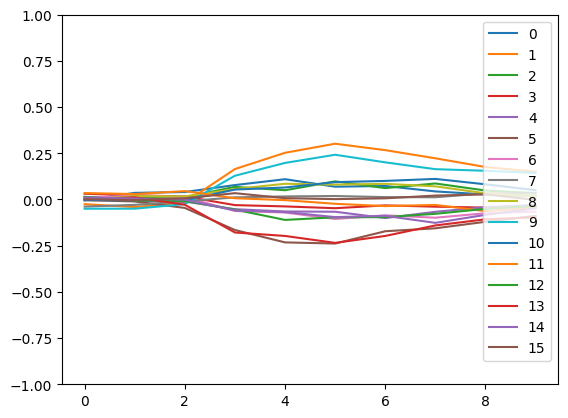

1[ 0.10960496  0.30169521  0.0980122   0.03098991  0.01305762 -0.00370739
  0.0223105   0.03311447  0.08503595  0.24201271  0.11129552  0.04535318
  0.01433394  0.0117986   0.01033939  0.03409246]


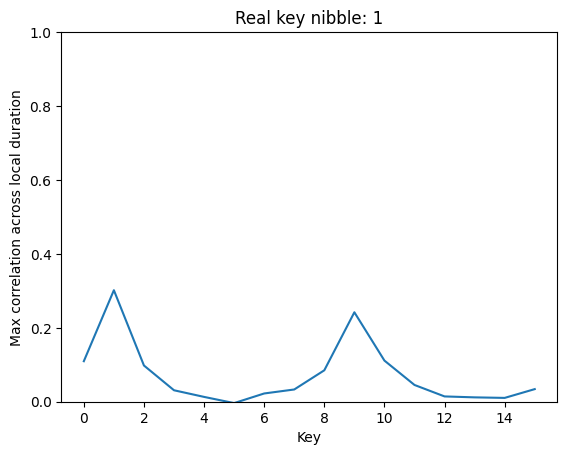

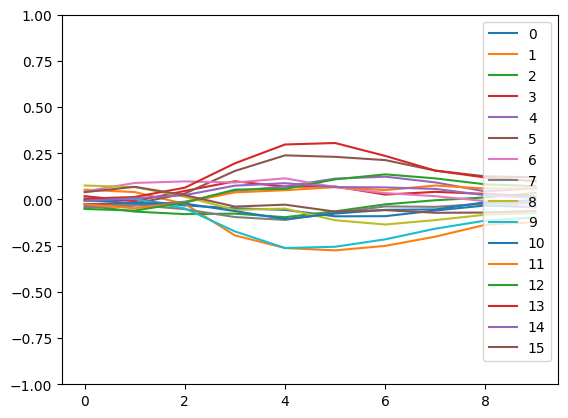

D[-0.00265111  0.05307226  0.0351219   0.0984216   0.12333685  0.23879073
  0.11441979 -0.0180418   0.07553938  0.00420295 -0.00381275  0.07554809
  0.13591009  0.30555221  0.08804267  0.06846279]


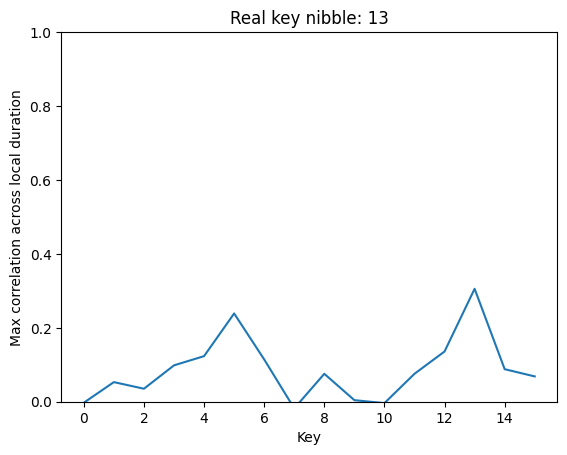

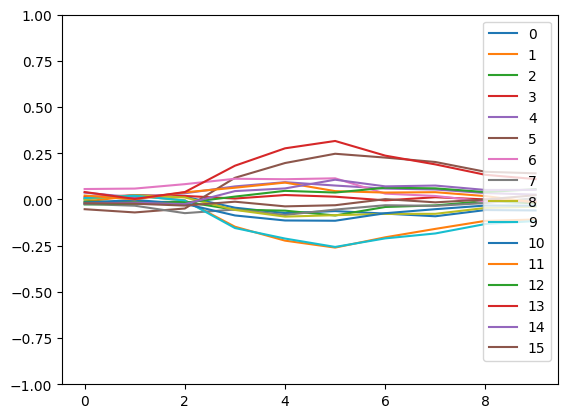

D[ 0.02254088  0.01994546 -0.0086752   0.02411288  0.09363553  0.24740633
  0.11449524  0.0074048   0.02231373  0.02002646 -0.00248637  0.09141479
  0.06339949  0.31657943  0.1069801   0.02326083]


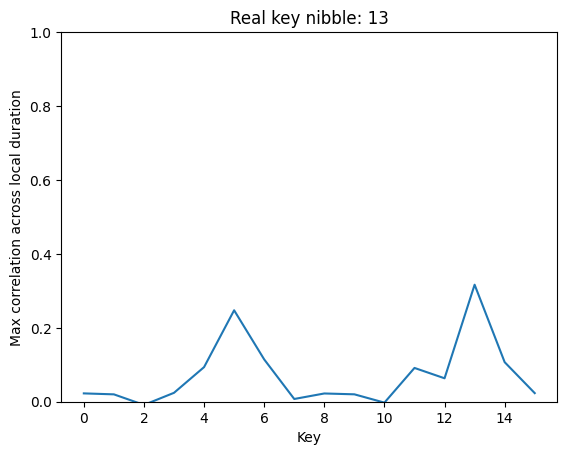

KeyboardInterrupt: 

In [12]:
reconstructed_keys = np.zeros_like(real_keys)
for i in range(reconstructed_keys.shape[0]):
    print(f"Key {i}: ", end="")
    visited = set()
    for j in range(reconstructed_keys.shape[1]):
        block_targets = [4]
        locs_and_hyps_per_block_target = indices_locations_and_hyps_to_use_for_each_key_nibble(j, block_targets, seeds[i], traces[i], correlation_locations)
        for k, block in enumerate(block_targets):
            selected_traces, hypotheses = locs_and_hyps_per_block_target[k]
            corrs = np.array([corr_coef_vectorized(hypotheses[l], selected_traces) for l in range(hypotheses.shape[0])])

            for l in range(len(corrs)):
                plt.plot(corrs[l], label=str(l))

            plt.ylim([-1, 1])
            plt.legend()
            plt.show()
            
            max_corrs = np.max(corrs, axis=1)
            best_k = np.argmax(max_corrs)
            reconstructed_keys[i][j] = best_k

            print(hex(best_k)[2:].upper(), end="")

            print(max_corrs)
            plt.plot(max_corrs)
            plt.xlabel("Key")
            plt.ylabel("Max correlation across local duration")
            plt.title(f"Real key nibble: {real_keys[i][j]}")
            plt.ylim([0, 1])
            plt.show()
    print()
    print(f"    vs {"".join([hex(k)[2:].upper() for k in real_keys[i]])}")
    print(f"{len(real_keys[i][real_keys[i] != reconstructed_keys[i]])} mistakes on {len(real_keys[i])} nibbles.")
    print()

## Try with less traces

In [31]:
np.random.seed(0)
num_traces_choices = [150_000]

reconstructed_keys = np.zeros((len(num_traces_choices),) + real_keys.shape)
for i in range(reconstructed_keys.shape[1]):
    for j in range(reconstructed_keys.shape[2]):
        print(j, end="\r")
        block_targets = [4]
        for n, num_traces in enumerate(num_traces_choices):
            used_sample = np.random.choice(traces.shape[1], size=num_traces, replace=False)
            locs_and_hyps_per_block_target = indices_locations_and_hyps_to_use_for_each_key_nibble(j, block_targets, seeds[i][used_sample], traces[i][used_sample], correlation_locations)
            for k, block in enumerate(block_targets):
                selected_traces, hypotheses = locs_and_hyps_per_block_target[k]
                corrs = np.array([corr_coef_vectorized(hypotheses[l], selected_traces) for l in range(hypotheses.shape[0])])

                max_corrs = np.max(corrs, axis=1)
                best_k = np.argmax(max_corrs)
                reconstructed_keys[n][i][j] = best_k

In [30]:
# 50_000 traces, 100_000 traces
np.count_nonzero(reconstructed_keys == real_keys, axis=2)[:, 0] / KEY_WIDTH_B4

array([0.8671875, 0.9609375])

In [32]:
# 150_000 traces
np.count_nonzero(reconstructed_keys == real_keys, axis=2)[:, 0] / KEY_WIDTH_B4

array([0.97851562])

We still do not recover the entire key with 150'000 traces. 250'000 does so. We use only 2 rounds out of 14 -> 250'000/14 = 35'000 with all rounds.